In [5]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime, timedelta
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# test set
start_date = datetime(2020,7,1,0)
end_date = datetime(2021,6,30,23)

sat_mis = np.load('../processed_data/sat_missing_date_ar.npy',allow_pickle=True)
rad_mis = np.load('../processed_data/rad_missing_date_ar.npy',allow_pickle=True)
sat =  np.load('../processed_data/sat_images_feature.npy')
rad =  np.load('../processed_data/rad_images_feature.npy')
aws = pd.read_csv('../processed_data/aws.csv')
aws['시각'] = pd.to_datetime(aws['시각'])
df = pd.read_csv('../processed_data/target.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.loc[:,df.columns[1:]]
weather = ['강풍','풍랑','호우','대설','건조','폭풍해일','한파','태풍','황사',
          '폭염','지진해일','화산재','급변풍']
region = ['서울·인천·경기도','부산·울산·경상남도','대구·경상북도',
'광주·전라남도','전라북도','대전·세종·충청남도','충청북도','강원도','제주도']

In [6]:
# making dataset
first = True
count = 0

rad_count = 0
sat_count = 0

sat_mean = np.mean(sat)
sat_std = np.std(sat)
rad_mean = np.mean(rad)
rad_std = np.std(rad)
temp_mean = np.mean(aws.loc[:,'평균 기온'].values)
temp_std = np.std(aws.loc[:,'평균 기온'].values)
rain_mean = np.mean(aws.loc[:,'합계 강수량'].values)
rain_std = np.std(aws.loc[:,'합계 강수량'].values)

with tqdm(total = 365*24) as pbar:
    while start_date <= end_date:
        pbar.update(1)
        check = False
        
        rad_c = Counter(rad_mis==start_date)
        sat_c = Counter(sat_mis==start_date)

        
        try :
            temperature = aws.loc[(aws['시각'] == start_date),'평균 기온'].values
            temperature = (temperature-temp_mean)/temp_std
            rain = aws.loc[(aws['시각'] == start_date),'합계 강수량'].values
            rain = (rain-rain_mean)/rain_std
            temp_sat = (sat[sat_count].flatten() - sat_mean)/sat_std
            temp_rad = (rad[rad_count].flatten() - rad_mean)/rad_std

            temp = []
            for reg in region:
                temp.append(df.loc[(df['datetime']==start_date),reg+'_호우'].values[0])
            heavy_rain = np.array(temp)
            heavy_rain = heavy_rain.astype(np.float64)
            #label smoothing
            heavy_rain[heavy_rain>0] = 0.9
            heavy_rain[heavy_rain<=0] = 0.1

            temp = []
            for reg in region:
                temp.append(df.loc[(df['datetime']==start_date),reg+'_폭염'].values[0])
            heat = np.array(temp)
            heat = heat.astype(np.float64)
            #label smoothing
            heat[heat>0] = 0.9
            heat[heat<=0] = 0.1

            temp = []
            for reg in region:
                temp.append(df.loc[(df['datetime']==start_date),reg+'_대설'].values[0])
            snow = np.array(temp)
            snow = snow.astype(np.float64)
            #label smoothing
            snow[snow>0] = 0.9
            snow[snow<=0] = 0.1

            comb = np.concatenate([rain,temperature,temp_sat,temp_rad])

            sat_count+=1
            rad_count+=1

            if (sat_c[True] != 0) :
                sat_count-=1
                check = True
            if  (rad_c[True] != 0) : 
                rad_count-=1
                check = True
            if check :
                start_date = start_date + timedelta(hours=1)
                continue
            if first :
                X = comb
                rains = heavy_rain
                heats = heat
                snows = snow
                first = False
            else : 
                X = np.vstack([X,comb])
                rains = np.vstack([rains,heavy_rain])
                heats = np.vstack([heats,heat])
                snows = np.vstack([snows,snow])
        except Exception as e :
            print(e)
            print(start_date)
        start_date = start_date + timedelta(hours=1)
np.save('../processed_data/LSTM_X.npy',X)
np.save('../processed_data/LSTM_rain.npy',rains)
np.save('../processed_data/LSTM_heat.npy',heats)
np.save('../processed_data/LSTM_snow.npy',snows)

  0%|          | 0/8760 [00:00<?, ?it/s]

2020-07-01 00:00:00


  0%|          | 28/8760 [00:04<25:31,  5.70it/s]


KeyboardInterrupt: 

In [15]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime, timedelta
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm 

def delete_black_line(pil_image):
    temp = pil_image
    indx = [1,1,-1,-1]
    indy = [1,-1,1,-1]
    for i in range(temp.size[0]):
        for j in range(temp.size[1]):
            r,g,b = temp.getpixel((i,j))
            if  (r==140) &(g==140)&(b==140):
                temp.putpixel((i,j),(250,250,250))
            elif  (r==163) &(g==163)&(b==163):
                temp.putpixel((i,j),(250,250,250))
            elif  (r==224) &(g==224)&(b==224):
                temp.putpixel((i,j),(250,250,250))
    
    for i in range(temp.size[0]):
        for j in range(temp.size[1]):
            r,g,b = temp.getpixel((i,j))
            if (r==0) &(g==0)&(b==0):
                re_r, re_g, re_b = 0,0,0
                count = 0
                for k in range(4):
                    try :
                        r,g,b = temp.getpixel((i+indx[k],j+indy[k]))
                        if  not((r==0) & (g==0) & (b==0)):
                            re_r += r
                            re_g += g
                            re_b += b
                            count+=1
                    except :
                        continue
                if count != 0 :
                    temp.putpixel((i,j),(int(re_r/count),int(re_g/count),int(re_b/count)))
                else : 
                    temp.putpixel((i,j),(250,250,250))
    return temp
def delete_black_line_(pil_image):
    temp = pil_image
    indx = [1,1,-1,-1]
    indy = [1,-1,1,-1]
    pxl_list = []
    for i in range(temp.size[0]):
        for j in range(temp.size[1]):
            r = temp.getpixel((i,j))
            if  (r==28) :
                temp.putpixel((i,j),(0))
                pxl_list.append((i,j))
            elif  (r==25) :
                temp.putpixel((i,j),(0))
    for i in range(len(pxl_list)):
        re= 0,0,0
        count = 0
        for k in range(4):
            try:
                r = temp.getpixel((pxl_list[i][0]+indx[k],pxl_list[i][1]+indy[k]))
            except :
                continue
        try:
            if count != 0 :
                temp.putpixel((i,j),(int(re/count)))
            else : 
                temp.putpixel((i,j),(0))
        except:
            continue
    return temp
def fill_black(array, coor_x, coor_y):
    index = [1,1,-1,-1]
    indey = [1,-1,1,-1]
    for i in range(len(coor_x)):
        cum = 0
        count = 0
        for k in range(4):
            try :
                temp = array[coor_x[i]+index[k],coor_y[i]+indey[k]]
                cum+= temp
                count +=1
            except :
                continue
        try:
            array[coor_x[i],coor_y[i]] = int(cum/count)
        except:
            continue
    return array


# test set
START_DATE  = datetime(2020,7,1,0,0)
END_DATE = datetime(2021,6,30,23,0)
path = '/mat/ai-nas02/WORK/szw001/com'


NOW_DATE = START_DATE
images = []
missing_date = []
use_date =[]
before_crop = (1,1,526,575)
after_crop = (1,21,601,621)

img = Image.open('../processed_data/rad_template_1.png')
img_1 = np.array(img)
x_1,y_1 = np.where(img_1 == 0)

img = Image.open('../processed_data/rad_template_2.png')
img_2 = np.array(img)
x_2,y_2 = np.where(img_2 == 28)

img = Image.open('../processed_data/rad_template_3.png')
img_3 = np.array(img)
x_3,y_3 = np.where(img_3 == 0)


In [29]:


NOW_DATE = datetime(2021,1,7,9,0)
#while NOW_DATE <= END_DATE:
if NOW_DATE <= datetime(2019,1,7,9,0):
    crop_tuple = before_crop
    template = img_1
    indx = x_1
    indy = y_1
    preprocessing = delete_black_line
elif (NOW_DATE >= datetime(2019,1,7,10,0)) & (NOW_DATE <= datetime(2020,10,7,9,0)):
    crop_tuple = after_crop
    template = img_2
    indx = x_2
    indy = y_2
    preprocessing = delete_black_line_
else:
    crop_tuple = after_crop
    template = img_3
    indx = x_3
    indy = y_3
    preprocessing = delete_black_line
try:
    
    img = Image.open(os.path.join(path,NOW_DATE.strftime('%Y%m/%Y%m%d%H%M_RAD_COMP.png')))
    img = img.crop(crop_tuple)
    img = preprocessing(img)
    img = img.convert('L')
    img = img.resize((600,600))
    imgarr = np.array(img)
    imgarr = fill_black(imgarr,indx,indy)
    imgarr = imgarr.reshape(1,imgarr.shape[0],imgarr.shape[1])
    images.append(imgarr)
    use_date.append(NOW_DATE)

except :
    missing_date.append(NOW_DATE)

NOW_DATE = NOW_DATE+timedelta(hours=1)

In [21]:
indx

array([  0,   0,   0, ..., 599, 599, 599])

In [3]:


img = img.convert('L')
img = img.resize((600,600))
imgarr = np.array(img)
imgarr = imgarr.reshape(1,imgarr.shape[0],imgarr.shape[1])
images.append(imgarr)
use_date.append(NOW_DATE)

[datetime.datetime(2020, 7, 1, 0, 0)]

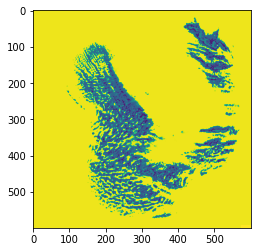

In [32]:
import  matplotlib.pyplot as plt
plt.imshow(imgarr[0])

In [14]:
img = Image.open(os.path.join(path,NOW_DATE.strftime('%Y%m/%Y%m%d%H%M_RAD_COMP.png')))
img = img.crop(crop_tuple)
img = preprocessing(img)

IndexError: image index out of range

In [ ]:
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, trange
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

names = np.array(['LLJ', 'W_SNOW','E_SNOW','WET_SN','CUM_SN','COLD_FRONT','WARM_FRONT','OCC_FRONT','H_POINT','L_POINT'
                ,'HLJ', 'TYPOON', 'R_START', 'R_STOP','RA_SN','HAIL'])

modes = ['sat','rad']
eval_path = "../final_output"

for name in names:
    for mode in modes:
        print(name,mode,'data_loading..')
        pred = np.load(os.path.join(eval_path,name+'_'+mode+'_pred.npy'))
        target = np.load(os.path.join(eval_path,name+'_'+mode+'_target.npy'))
        print('test dataset length :',len(pred))
        target[target >0.5] = 1
        target[target <=0.5] = 0
        precision, recall, thresholds = precision_recall_curve(target.flatten(), pred.flatten())
        f1 = 2*(precision*recall)/(precision+recall)
        f1 = np.nan_to_num(f1)
        print('max f1 :',np.max(f1))
        thr = thresholds[np.argmax(f1)]

        pred[pred >thr] = 1
        pred[pred <=thr] = 0
        tn, fp, fn, tp = confusion_matrix(target.flatten(), pred.flatten()).ravel()
        print(confusion_matrix(target.flatten(), pred.flatten()))

        print('acc : ',(tn+tp)/(tn+fp+fn+tp))

In [2]:
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, trange
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

mode = 'sat'
name = 'HAIL'
eval_path = "/home/eval/final_output"

print(name,mode,'data_loading..')
pred = np.load(os.path.join(eval_path,name+'_'+mode+'_pred.npy'))
target = np.load(os.path.join(eval_path,name+'_'+mode+'_target.npy'))
print('test dataset length :',len(pred))
target[target >0.5] = 1
target[target <=0.5] = 0
precision, recall, thresholds = precision_recall_curve(target.flatten(), pred.flatten())
f1 = 2*(precision*recall)/(precision+recall)
f1 = np.nan_to_num(f1)
print('max f1 :',np.max(f1))
thr = thresholds[np.argmax(f1)]

pred[pred >thr] = 1
pred[pred <=thr] = 0
tn, fp, fn, tp = confusion_matrix(target.flatten(), pred.flatten()).ravel()
print(confusion_matrix(target.flatten(), pred.flatten()))

print('acc : ',(tn+tp)/(tn+fp+fn+tp))

HAIL sat data_loading..
test dataset length : 0


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [15]:
import argparse
import configparser
import warnings
warnings.simplefilter('ignore',UserWarning)

from pytorch_lightning.trainer.trainer import Trainer
import torch
import torchmetrics
import torch.nn.functional as F
from torch import nn
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d, ConvTranspose2d
from torch.nn.modules.pooling import MaxPool2d
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pl_examples import _DATASETS_PATH, cli_lightning_logo
from pl_examples.basic_examples.mnist_datamodule import MNIST
from pytorch_lightning.utilities.cli import LightningCLI
from pytorch_lightning.utilities.imports import _TORCHVISION_AVAILABLE
from pytorch_lightning import loggers as pl_loggers
from PIL import Image, ImageDraw
from datetime import datetime,timedelta
import numpy as np
import os
from tqdm import tqdm, trange
import pandas as pd
if _TORCHVISION_AVAILABLE:
    from torchvision import transforms
    
cuda = torch.device('cuda')

print((datetime.now()+timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:%S'))
print("LSTM evaluation..")

class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray,Y: np.ndarray, seq_len: int = 24):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.Y[index+self.seq_len])

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = input_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.BatchNorm1d(8560),
            nn.Dropout(0.2),
            nn.Linear(8560, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 9),
            nn.Sigmoid()
        )
        #self.linear = nn.Linear(hidden_size, input_size)   
    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        output = self.linear(lstm_out[:,-1])
        #weather = F.sigmoid(output[-9:])
        #output = torch.cat((output[:-9],weather))
        return output,lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = input_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.BatchNorm1d(8560),
            nn.Dropout(0.2),
            nn.Linear(8560, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 9),
            nn.Sigmoid()
        )
        #self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input, encoder_hidden_states)
        output = self.linear(lstm_out[:,-1])
        #weather = F.sigmoid(output[-9:])
        #output = torch.cat((output[:-9],weather))
        
        return output,lstm_out, self.hidden

class LitAutoEncoder(pl.LightningModule):
    """
    >>> LitAutoEncoder()  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    LitAutoEncoder(
      (encoder): ...
      (decoder): ...
    )
    """

    def __init__(self, hidden_size: int = 16, input_size: int=8560):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

        self.criterion = F.binary_cross_entropy

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        lstm_out, state,_ = self.encoder(x)
        return lstm_out,state, _

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat,state,_ = self(x)
        loss = self.criterion(y_hat, y)
        #loss = torch.cat((loss,F.binary_cross_entropy(y_hat[-9:], y[-9:])))
        self.log("my_loss", loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat,state,_ = self(x)
        loss = self.criterion(y_hat, y)
        #loss = torch.cat((loss,F.binary_cross_entropy(y_hat[-9:], y[-9:])))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat,state,_ = self(x)
        loss = self.criterion(y_hat, y)
        #loss = torch.cat((loss,F.binary_cross_entropy(y_hat[-9:], y[-9:])))
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def first_predict(self, x):
        lstm_out,state, _ = self.encoder(x)
        return lstm_out,state, _

    def second_predict(self, x, hidden):
        lstm_out,state, _ = self.decoder(x,hidden)
        return lstm_out,state, _


config = configparser.ConfigParser()    
config.read('setting.ini', encoding='utf-8') 

test_path = config['path']['test_path']
model_path = config['path']['model_path']


name = 'heat'
#set root
timestep = 24
seq_len = 24
print('dataset X loading..')
dataset = np.load(os.path.join(test_path,'processed_data/LSTM_X.npy'))

print(name,'target loading..')
target = np.load(os.path.join(test_path,'processed_data/LSTM_'+name+'.npy'))

original_list = []
result_list = []


2022-01-11 14:38:41
LSTM evaluation..
dataset X loading..
heat target loading..


In [14]:
snow_data = dataset

In [3]:
timestep

24

In [4]:
seq_len

24

In [16]:
start = 0
test_set = dataset[start:start+timestep]
test_set = torch.Tensor(test_set).cuda()
test_set = test_set.reshape(1,test_set.shape[0],test_set.shape[1])

In [9]:
test_set.shape


torch.Size([1, 24, 8560])

In [20]:
model.first_predict(test_set)

(tensor([[1., 0., 0., 1., 1., 1., 1., 0., 0.]], device='cuda:0',
        grad_fn=<SigmoidBackward>),
 tensor([[[-6.6774e-24,  7.5942e-01,  8.9042e-05,  ..., -1.2789e-03,
            3.3047e-08,  1.0835e-36],
          [-3.3713e-26,  9.6365e-01,  1.6846e-08,  ..., -6.3032e-09,
            3.4695e-16,  0.0000e+00],
          [-9.2689e-29,  9.9500e-01,  9.8115e-09,  ..., -7.2684e-10,
            6.1581e-17,  0.0000e+00],
          ...,
          [-3.1732e-30,  1.0000e+00,  3.6515e-09,  ..., -4.5412e-10,
            1.4200e-17,  0.0000e+00],
          [-5.8316e-30,  1.0000e+00,  5.2425e-09,  ..., -4.4021e-10,
            2.4922e-17,  0.0000e+00],
          [-9.3015e-30,  1.0000e+00,  6.8851e-09,  ..., -4.4155e-10,
            3.7977e-17,  0.0000e+00]]], device='cuda:0',
        grad_fn=<CudnnRnnBackward>),
 (tensor([[[-9.3015e-30,  1.0000e+00,  6.8851e-09,  ..., -4.4155e-10,
             3.7977e-17,  0.0000e+00]]], device='cuda:0',
         grad_fn=<CudnnRnnBackward>),
  tensor([[[-9.3015e

In [11]:
model = LitAutoEncoder.load_from_checkpoint(os.path.join(model_path,'heat.ckpt'))
model = model.cuda()

In [19]:
model.eval()

LitAutoEncoder(
  (encoder): lstm_encoder(
    (lstm): LSTM(8560, 8560, batch_first=True)
    (linear): Sequential(
      (0): BatchNorm1d(8560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=8560, out_features=1024, bias=True)
      (3): ReLU()
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=128, bias=True)
      (7): ReLU()
      (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Dropout(p=0.2, inplace=False)
      (10): Linear(in_features=128, out_features=9, bias=True)
      (11): Sigmoid()
    )
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(8560, 8560, batch_first=True)
    (linear): Sequential(
      (0): BatchNorm1d(8560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, in

In [13]:
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, trange
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import configparser
print((datetime.now()+timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:%S'))
print("mask rcnn score calculation start..")

config = configparser.ConfigParser()    
config.read('setting.ini', encoding='utf-8') 

START_DATE = datetime.strptime(config['date']['start_date'],'%Y-%m-%d %H:%M:%S')
END_DATE = datetime.strptime(config['date']['end_date'],'%Y-%m-%d %H:%M:%S')
output_path = config['path']['output_path']
path = config['path']['test_path']



eval_path = os.path.join(path,'processed_data')

name = 'HAIL'
mode = 'sat'

print(name,mode,'data_loading..')
pred = np.load(os.path.join(eval_path,name+'_'+mode+'_pred.npy'))
target = np.load(os.path.join(eval_path,name+'_'+mode+'_target.npy'))
print('test dataset length :',len(pred))
target[target >0.5] = 1
target[target <=0.5] = 0
precision, recall, thresholds = precision_recall_curve(target.flatten(), pred.flatten())
f1 = 2*(precision*recall)/(precision+recall)
f1 = np.nan_to_num(f1)
print('max f1 :',np.max(f1))
thr = thresholds[np.argmax(f1)]

pred[pred >thr] = 1
pred[pred <=thr] = 0
try :
    tn, fp, fn, tp = confusion_matrix(target.flatten(), pred.flatten()).ravel()
except :
    tn = confusion_matrix(target.flatten(), pred.flatten()).ravel()[0]
    fp=0
    fn=0
    tp=0
res = np.array([[tn,fp],[fn,tp]])
print(res)

print('acc : ',(tn+tp)/(tn+fp+fn+tp))

2022-01-19 10:31:38
mask rcnn score calculation start..
HAIL sat data_loading..
test dataset length : 9
max f1 : 0.0
[[3600    0]
 [   0    0]]
acc :  1.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [3]:
from collections import Counter
Counter(target.flatten())

Counter()

In [18]:
name = 'rain'
test_path = config['path']['test_path']
pred = np.load(os.path.join(test_path,'processed_data/%s_result.npy'%(name)))
target = np.load(os.path.join(test_path,'processed_data/%s_origin.npy'%(name)))

In [19]:
pred.shape

(8570, 216)

In [20]:
import pandas as pd
temp = pd.read_csv('./target.csv')

In [22]:
col = temp.columns

In [32]:
region = ['서울·인천·경기도',
 '부산·울산·경상남도',
 '대구·경상북도',
 '광주·전라남도',
 '전라북도',
 '대전·세종·충청남도',
 '충청북도',
 '강원도',
 '제주도']
columns = []
for i in range(24):
    for reg in region:
        columns.append(str(i+1)+'hours'+'_'+reg)

In [36]:
test = pd.DataFrame(pred, columns=columns)

In [38]:
test.to_csv('./test.csv')

In [39]:
eval_path = os.path.join(path,'processed_data')

In [40]:
name = 'RA_SN'
mode = 'sat'

pred = np.load(os.path.join(eval_path,name+'_'+mode+'_pred.npy'))
target = np.load(os.path.join(eval_path,name+'_'+mode+'_target.npy'))


In [48]:
column =[]
for i in range(400):
    column.append('gridcell'+str(i+1))

In [49]:
column

['gridcell1',
 'gridcell2',
 'gridcell3',
 'gridcell4',
 'gridcell5',
 'gridcell6',
 'gridcell7',
 'gridcell8',
 'gridcell9',
 'gridcell10',
 'gridcell11',
 'gridcell12',
 'gridcell13',
 'gridcell14',
 'gridcell15',
 'gridcell16',
 'gridcell17',
 'gridcell18',
 'gridcell19',
 'gridcell20',
 'gridcell21',
 'gridcell22',
 'gridcell23',
 'gridcell24',
 'gridcell25',
 'gridcell26',
 'gridcell27',
 'gridcell28',
 'gridcell29',
 'gridcell30',
 'gridcell31',
 'gridcell32',
 'gridcell33',
 'gridcell34',
 'gridcell35',
 'gridcell36',
 'gridcell37',
 'gridcell38',
 'gridcell39',
 'gridcell40',
 'gridcell41',
 'gridcell42',
 'gridcell43',
 'gridcell44',
 'gridcell45',
 'gridcell46',
 'gridcell47',
 'gridcell48',
 'gridcell49',
 'gridcell50',
 'gridcell51',
 'gridcell52',
 'gridcell53',
 'gridcell54',
 'gridcell55',
 'gridcell56',
 'gridcell57',
 'gridcell58',
 'gridcell59',
 'gridcell60',
 'gridcell61',
 'gridcell62',
 'gridcell63',
 'gridcell64',
 'gridcell65',
 'gridcell66',
 'gridcell67',
 'gr

In [42]:
target = target.reshape(target.shape[0],400)

In [44]:
target.shape

(24, 400)

In [51]:
target_csv = pd.DataFrame(target, columns=column)

In [52]:
target_csv

,gridcell1,gridcell2,gridcell3,gridcell4,gridcell5,gridcell6,gridcell7,gridcell8,gridcell9,gridcell10,...,gridcell391,gridcell392,gridcell393,gridcell394,gridcell395,gridcell396,gridcell397,gridcell398,gridcell399,gridcell400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
import torch
import argparse
from PIL import Image
import os
import numpy as np
from PIL import Image
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
from typing import List, Tuple, Dict, Optional
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from datetime import datetime, timedelta
from collections import Counter
import utils
import configparser
print((datetime.now()+timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:%S'))
print("mask rcnn test start..")

class CustomDataset(object):
    def __init__(self, root,anno, transforms,mode, num=0):
        self.root = root
        self.transforms = transforms
        self.anno = anno    
        if mode == 'sat' :
            self.sats = np.load(os.path.join(root,anno,'sat.npy'))
        elif mode == 'rad' :
            self.sats = np.load(os.path.join(root,anno,'rad.npy'))
        else :
            print('wrong name')
        self.masks = np.load(os.path.join(root,anno,'mask.npy'))
        new_sat = self.sats
        new_mask = self.masks
        '''
        count = 0
        for mask in self.masks :
            c = Counter(mask.flatten())
            if c[1] >= 100 :
                new_sat.append(self.sats[count])
                new_mask.append(self.masks[count])
            count+=1
        '''
        self.sats = np.array(new_sat)
        self.sats = np.transpose(self.sats,(0,2,3,1))
        self.masks = np.array(new_mask)
        print(self.masks.shape)
        print(self.sats.shape)
        
    def __getitem__(self, idx):
        
        img = self.sats[idx]
        mask = self.masks[idx]
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = torch.tensor(100)
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.sats)

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    return Compose(transforms)

class ToTensor(nn.Module):
    def forward(self, image: Tensor,
                target: Optional[Dict[str, Tensor]] = None) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.to_tensor(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda = torch.device('cuda')

config = configparser.ConfigParser()    
config.read('setting.ini', encoding='utf-8') 

START_DATE = datetime.strptime(config['date']['start_date'],'%Y-%m-%d %H:%M:%S')
END_DATE = datetime.strptime(config['date']['end_date'],'%Y-%m-%d %H:%M:%S')
path = config['path']['test_path']
model_path = config['path']['model_path']


annos = ['LLJ', 'W_SNOW','E_SNOW','WET_SN','CUM_SN','COLD_FRONT','WARM_FRONT','OCC_FRONT','H_POINT','L_POINT'
        ,'HLJ', 'TYPOON', 'R_START', 'R_STOP','RA_SN','HAIL']
modes = ['sat','rad']

annos = ['LLJ']
modes = ['sat']

model_dir = model_path
data_path = os.path.join(path,'processed_data')
eval_path = os.path.join(path,'processed_data')

for anno in annos:
    for mode in modes:
        model = torch.load(os.path.join(model_dir,anno+'_'+mode+'.pt'))
        model = model.cuda()
        model.eval()

        dataset = CustomDataset(data_path,anno, get_transform(train=True),mode)

        data_loader_test = torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=False, num_workers=2,
            collate_fn=utils.collate_fn)

        target_arr = []
        preds = []
        print(anno+mode+'data loading finish..')

        for images, targets in data_loader_test:
            images = list(image.to(device) for image in images)
            target = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            for j in range(len(images)):
                try:
                    temp = output[j]['masks'][0].cpu().detach()[0].numpy()
                except Exception as e:
                    temp = np.zeros((900,900))
                try:
                    temp_target = target[j]['masks'][0].cpu().detach().numpy()
                except:
                    temp_target = np.zeros((900,900))

                pred = np.mean(temp.reshape(20,45,20,45),axis=(1,3))
                temp_target = np.mean(temp_target.reshape(20,45,20,45),axis=(1,3))
                preds.append(pred)
                target_arr.append(temp_target)

        np.save(os.path.join(eval_path,anno+'_'+mode+'_pred.npy'),preds)
        np.save(os.path.join(eval_path,anno+'_'+mode+'_target.npy'),target_arr)



2022-01-20 11:17:03
mask rcnn test start..


KeyboardInterrupt: 

In [12]:
target

[{'boxes': tensor([[186., 614., 301., 747.],
          [409., 665., 536., 826.]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8),
  'image_id': tensor([82], device='cuda:0'),
  'area': tensor(100, device='cuda:0'),
  'iscrowd': tensor([0, 0], device='cuda:0')}]

In [7]:
target_arr = []
preds = []
print(anno+mode+'data loading finish..')
for images, targets in data_loader_test:
    images = list(image.to(device) for image in images)
    target = [{k: v.to(device) for k, v in t.items()} for t in targets]

    output = model(images)
    for j in range(len(images)):
        try:
            temp = output[j]['masks'][0].cpu().detach()[0].numpy()
        except Exception as e:
            temp = np.zeros((900,900))
        pred = np.mean(temp.reshape(20,45,20,45),axis=(1,3))
        try : 
            temp_target = target[j]['masks'][0].cpu().detach().numpy()
        except : 
            print('test')
            continue
        temp_target = np.mean(temp_target.reshape(20,45,20,45),axis=(1,3))
        preds.append(pred)
        target_arr.append(temp_target)

LLJsatdata loading finish..
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test


KeyboardInterrupt: 

In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [50]:
output_path = config['path']['output_path']

annos = ['LLJ', 'W_SNOW','E_SNOW','WET_SN','CUM_SN','COLD_FRONT','WARM_FRONT','OCC_FRONT','H_POINT','L_POINT'
        ,'HLJ', 'TYPOON', 'R_START', 'R_STOP','RA_SN','HAIL']
modes = ['sat','rad']
val = []
for anno in annos:
        sat_pred = pd.read_csv(os.path.join(output_path,anno+'_sat_prediction.csv'))
        sat_target = pd.read_csv(os.path.join(output_path,anno+'_sat_target.csv'))
        rad_pred = pd.read_csv(os.path.join(output_path,anno+'_rad_prediction.csv'))
        rad_target = pd.read_csv(os.path.join(output_path,anno+'_rad_target.csv'))
        pred = pd.concat([sat_pred,rad_pred])
        target = pd.concat([sat_target,rad_target])
        np_pred = np.array(pred)
        np_target = np.array(target)
        try :
                tn, fp, fn, tp = confusion_matrix(np_target.flatten(), np_pred.flatten()).ravel()
        except :
                tn = confusion_matrix(np_target.flatten(), np_pred.flatten()).ravel()[0]
                fp=0
                fn=0
                tp=0
        
        try :
                precision = tp/(tp+fp)
                recall = tp/(tp+fn)
                f1 = 2*(precision*recall)/(precision+recall)
        except : 
                f1 = 0
        val.append(np.round(f1*100,1))
        print(anno,str(np.round(f1*100,1))+'%')
        '''
        print('f1-score :',f1)
        res = np.array([[tn,fp],[fn,tp]])
        print(res)
        print('acc : ',(tn+tp)/(tn+fp+fn+tp))
        print('\n\n')
        '''


LLJ 5.2%
W_SNOW 64.1%
E_SNOW 36.8%
WET_SN 34.7%
CUM_SN 6.7%
COLD_FRONT 7.9%
WARM_FRONT 5.4%
OCC_FRONT 16.6%
H_POINT 1.6%
L_POINT 3.3%
HLJ 11.0%
TYPOON 18.4%
R_START 16.8%
R_STOP 19.6%
RA_SN 22.4%
HAIL 0%


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

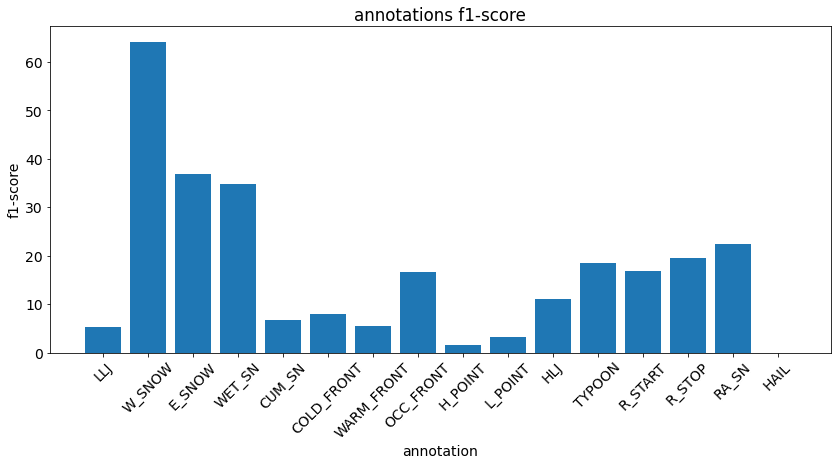

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 14})
plt.title('annotations f1-score')
plt.bar(annos,val)
plt.xlabel('annotation')
plt.ylabel('f1-score')
plt.xticks(rotation=45)

In [31]:
anno = 'LLJ'
sat_pred = pd.read_csv(os.path.join(output_path,anno+'_sat_prediction.csv'))
sat_target = pd.read_csv(os.path.join(output_path,anno+'_sat_target.csv'))
rad_pred = pd.read_csv(os.path.join(output_path,anno+'_rad_prediction.csv'))
rad_target = pd.read_csv(os.path.join(output_path,anno+'_rad_target.csv'))
pred = pd.concat([sat_pred,rad_pred])
target = pd.concat([sat_target,rad_target])
np_pred = np.array(pred)
np_target = np.array(target)
try :
    tn, fp, fn, tp = confusion_matrix(np_target.flatten(), np_pred.flatten()).ravel()
except :
    tn = confusion_matrix(np_target.flatten(), np_pred.flatten()).ravel()[0]
    fp=0
    fn=0
    tp=0
print(anno,'results')
try :
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
except : 
    f1 = 0
print('f1-score :',f1)
res = np.array([[tn,fp],[fn,tp]])
print(res)
print('acc : ',(tn+tp)/(tn+fp+fn+tp))
print('\n\n')

LLJ results
f1-score : 0.05210706150341686
[[882236  20920]
 [  5712    732]]
acc :  0.970721196130167





In [34]:
tn = 1643409
fp = 141187
fn = 62838
tp = 3686
try :
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
except : 
    f1 = 0
print('f1-score :',f1)

f1-score : 0.03487277492111998


In [35]:
tn = 1662999
fp = 117033
fn = 67165
tp = 3923
try :
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
except : 
    f1 = 0
print('f1-score :',f1)

f1-score : 0.04085522067859449


In [36]:
tn = 1697305
fp = 116495
fn = 36622
tp = 698
try :
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
except : 
    f1 = 0
print('f1-score :',f1)

f1-score : 0.009034838492554025


In [16]:
output_path = config['path']['output_path']

annos = ['LLJ', 'W_SNOW','E_SNOW','WET_SN','CUM_SN','COLD_FRONT','WARM_FRONT','OCC_FRONT','H_POINT','L_POINT'
        ,'HLJ', 'TYPOON', 'R_START', 'R_STOP','RA_SN','HAIL']
modes = ['sat','rad']

anno = annos[1]

mode = 'sat'
pred = pd.read_csv(os.path.join(output_path,anno+'_'+mode+'_prediction.csv'))
target = pd.read_csv(os.path.join(output_path,anno+'_'+mode+'_target.csv'))

In [20]:
pd.concat([pred,target])

,gridcell1,gridcell2,gridcell3,gridcell4,gridcell5,gridcell6,gridcell7,gridcell8,gridcell9,gridcell10,...,gridcell391,gridcell392,gridcell393,gridcell394,gridcell395,gridcell396,gridcell397,gridcell398,gridcell399,gridcell400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
